## Model Selection

In [23]:
import os
import pickle
import numpy as np
import pandas as pd

from src.binary_classification import classification as bc
from src.binary_classification.models import Model
current_path = os.getcwd()

In [24]:
DATASET_PATH = os.path.join(current_path, "outputs/processed_and_reduced_dataset.pkl")
OUTPUT_PATH = os.path.join(current_path, "outputs")

### Load data

In [25]:
try:
    # Open the pickle file and load the data
    with open(DATASET_PATH, 'rb') as f:
        X, y, X_test, y_test = pickle.load(f)

    # Check if the loaded objects are pandas DataFrames or convert them if necessary
    if isinstance(X, (list, np.ndarray)):
        X = pd.DataFrame(X)
    if isinstance(y, (list, np.ndarray)):
        y = pd.Series(y)
    if isinstance(X_test, (list, np.ndarray)):
        X_test = pd.DataFrame(X_test)
    if isinstance(y_test, (list, np.ndarray)):
        y_test = pd.Series(y_test)

    # Print the datasets
    print("Training set features (X):")
    print(X.head())
    print("\nTraining set labels (y):")
    print(y.head())

    print("\nTest set features (X_test):")
    print(X_test.head())
    print("\nTest set labels (y_test):")
    print(y_test.head())

except FileNotFoundError:
    print(f"Error: The file '{DATASET_PATH}' was not found.")
except pickle.UnpicklingError:
    print("Error: There was an issue unpickling the data. The file may be corrupted.")
except EOFError:
    print("Error: The file is empty or incomplete.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Training set features (X):
   area_mean  concavity_mean  concave points_mean   area_se  radius_worst  \
0   0.691610        0.395163             0.507400  0.472457      0.578471   
1   0.362187        0.203067             0.208448  0.467301      0.347399   
2   0.498481        0.505774             0.546214  0.341486      0.407059   
3   0.421139        0.318536             0.415296  0.285639      0.346324   
4   0.305749        0.217017             0.319328  0.234987      0.239652   

   texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0       0.529685         0.571194    0.612879          0.553602   
1       0.679156         0.344897    0.363079          0.461059   
2       0.512838         0.423435    0.419624          0.556873   
3       0.406968         0.349080    0.374273          0.543715   
4       0.453282         0.240776    0.255628          0.597075   

   concavity_worst  concave points_worst  symmetry_worst  
0         0.387940              0.560590        

## Logistic Regression

**Default params:**

In [26]:
model_obj = Model('LogisticRegression', optimization=False)

{'penalty': 'l2', 'c_reg': 1.0, 'solver': 'lbfgs', 'max_iter': 100}


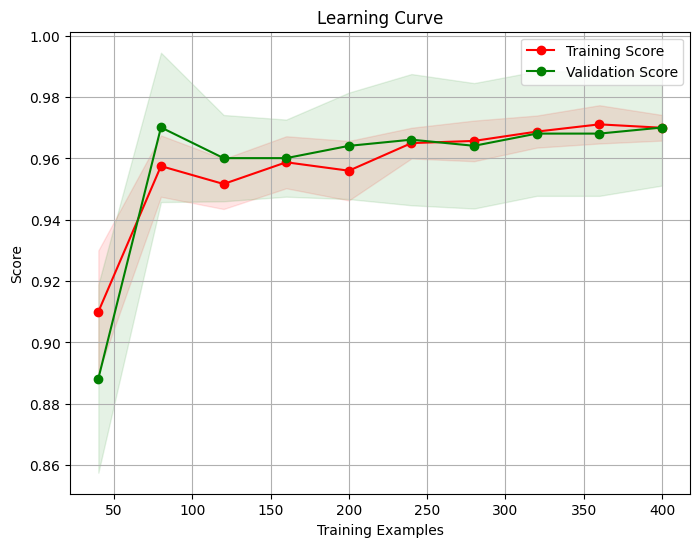

In [27]:
print(model_obj.hyperparameters)
bc.plot_learning_curve(model_obj, X, y, cv=5)

The learning curve indicates that the model has a high accuracy and generalizes well to new data. The gap between training and validation scores is small, and both scores are high, suggesting that the model is well-suited for the problem at hand. There is a minor variability in performance, but overall, the model's performance is robust and consistent as the training set size increases.

For model LogisticRegression with {'penalty': 'l2', 'c_reg': 1.0, 'solver': 'lbfgs', 'max_iter': 100}:

Results for train set:

   accuracy  precision  recall      f1  auc_roc
0    0.9721     0.9942  0.9297  0.9609   0.9633

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9821        1.0  0.9524  0.9756   0.9762


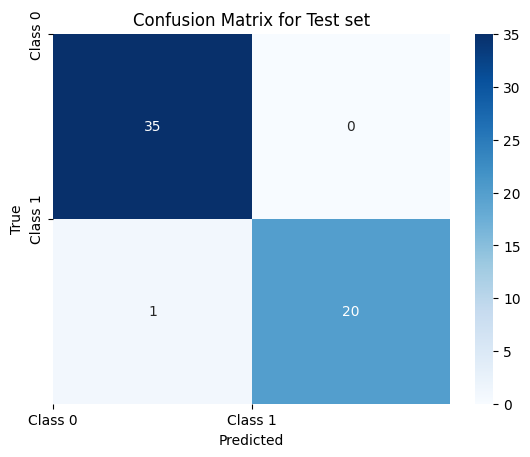

In [28]:
bc.train_and_evaluate_model(model_obj,
                            X.copy(), y.copy(),
                            X_test.copy(), y_test.copy())

From the confusion matrix in can be concluded that the model is able to predict with a perfect accuracy the class 0 and has a prety good accuracy on predicting the class 1 on unseen data. So it seems the model is able to generalize well.

**Hyperparameter optimization:**

In [29]:
# Hyperparameter_optimization
model_obj = Model('LogisticRegression', optimization=True)
print(f'Hyperparameters to optimize : {model_obj.hyperparams_to_optimize}')
best_params = bc.hyperparameter_optimization(model_obj.model,
                                             model_obj.hyperparams_to_optimize,
                                             X.copy(),
                                             y.copy(),
                                             cv=8)

Hyperparameters to optimize : {'penalty': ['l2'], 'C': [1000, 10000, 20000, 30000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [10000, 15000, 20000]}
Best hyperparameters found: {'C': 1000, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.9781


{'penalty': 'l2', 'c_reg': 1000, 'solver': 'newton-cg', 'max_iter': 10000}


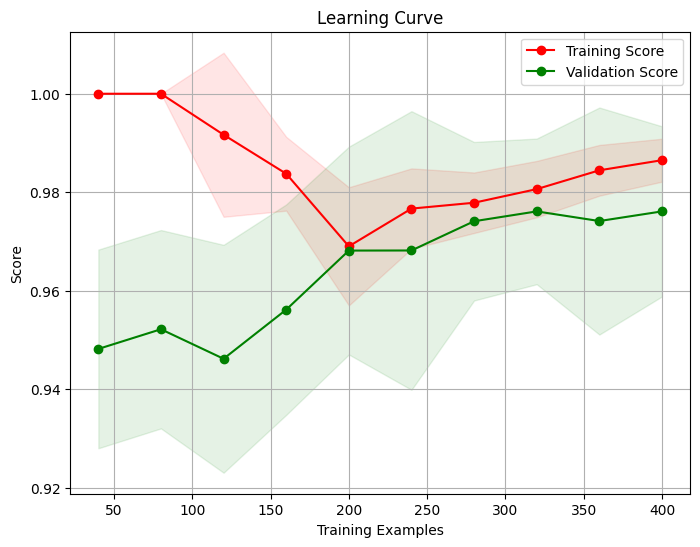

In [30]:
# Study with best params.
log_reg = Model('LogisticRegression', kwargs=best_params)
print(log_reg.hyperparameters)
bc.plot_learning_curve(log_reg, X.copy(), y.copy(), cv=5)

The learning curve indicates that with an increasing number of training examples, the model's performance on the validation set improves and stabilizes, while the training score decreases slightly but also stabilizes. This suggests that the model benefits from more data, leading to better generalization. The convergence of the training and validation scores is a positive sign of the model's ability to generalize well to unseen data.

**Optimized model:**

For model LogisticRegression with {'penalty': 'l2', 'c_reg': 1000, 'solver': 'newton-cg', 'max_iter': 10000}:

Results for train set:

   accuracy  precision  recall     f1  auc_roc
0     0.986     0.9837  0.9784  0.981   0.9844

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9643     0.9524  0.9524  0.9524   0.9619


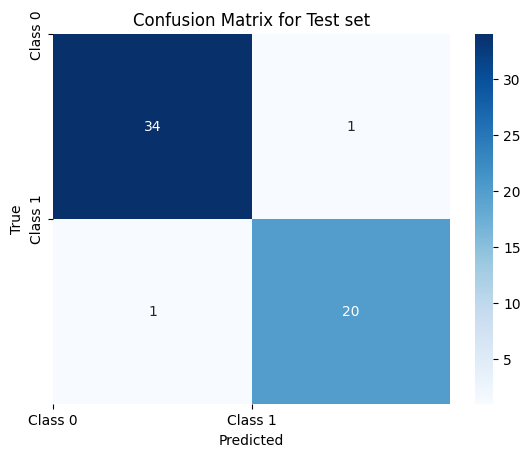

In [31]:
bc.train_and_evaluate_model(log_reg, 
                            X.copy(), y.copy(),
                            X_test.copy(), y_test.copy(),
                            save_outputs=True, output_dir=OUTPUT_PATH)

The confusion matrix from the optimized model has slightly improved on the prediction of class 1. 

Final scores for logistic regression:

| Accuracy | Precision | Recall | F1 Score | AUC ROC |
|----------|-----------|--------|----------|---------|
| 0.9643   | 0.9524    | 0.9524 | 0.9524   | 0.9619  |

### DecisionTree

**Default params:**

In [32]:
model_obj = Model('DecisionTree', optimization=False)

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


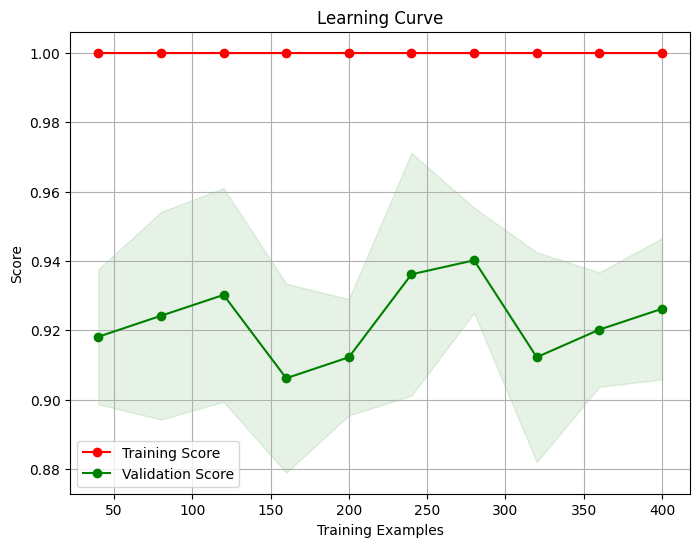

In [33]:
print(model_obj.hyperparameters)
bc.plot_learning_curve(model_obj, X.copy(), y.copy(), cv=5)

The training score (red line) is consistently 1.0, indicating that the model is perfectly fitting the training data. This is a strong sign of overfitting, as the model has learned the training data too well, capturing noise along with the underlying patterns.

The validation score (green line) fluctuates around 0.90 to 0.94, indicating that the model's performance on unseen data is significantly lower than on the training data. This supports the indication of overfitting.
The validation score does not significantly improve or stabilize as the training size increases, suggesting that adding more data alone may not resolve the overfitting issue.

The shaded area around the validation score indicates the variance. There is considerable fluctuation in the validation score, which might suggest that the model's performance on validation data is not stable.

For model DecisionTree with {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}:

Results for train set:

   accuracy  precision  recall   f1  auc_roc
0       1.0        1.0     1.0  1.0      1.0

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.8929     0.8261  0.9048  0.8636   0.8952


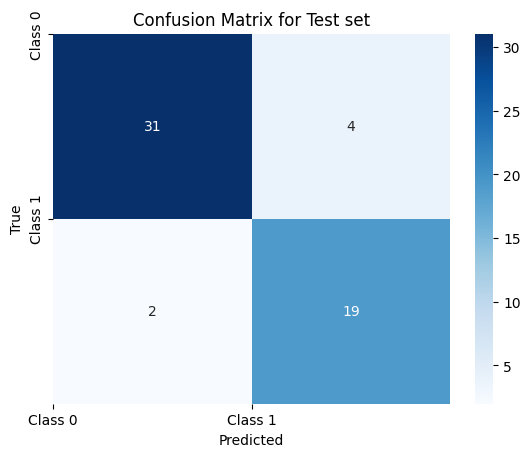

In [34]:
bc.train_and_evaluate_model(model_obj,
                            X.copy(), y.copy(),
                            X_test.copy(), y_test.copy())

**Hyperparameter optimization:**

In [35]:
# Hyperparameter_optimization
model_obj = Model('DecisionTree', optimization=True)
print(f'Hyperparameters to optimize : {model_obj.hyperparams_to_optimize}')
best_params = bc.hyperparameter_optimization(model_obj.model,
                                             model_obj.hyperparams_to_optimize,
                                             X.copy(),
                                             y.copy(),
                                             cv=8)

Hyperparameters to optimize : {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', 0.5]}
Best hyperparameters found: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9562


{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


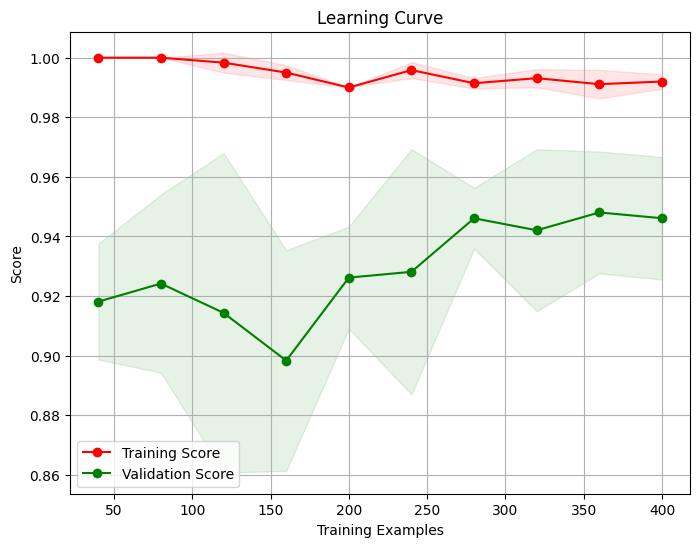

In [36]:
# Study with best params.
decision_tree = Model('DecisionTree', kwargs=best_params)
print(decision_tree.hyperparameters)
bc.plot_learning_curve(decision_tree, X.copy(), y.copy(), cv=5)

The training score (red line) starts at around 0.94 and quickly rises to about 0.98, then slightly decreases but remains relatively stable between 0.97 and 0.98. This indicates that the model is performing very well on the training data.

The validation score (green line) starts around 0.90 and fluctuates between 0.92 and 0.95, showing some improvement as the training data size increases.

The validation score increases and stabilizes, suggesting that the model's performance on unseen data is improving with more training data, but the improvement is limited.
There is a noticeable variance in the validation score, which indicates that the model's performance on validation data varies with different training set sizes.

The variance in the training score decreases as the training size increases, indicating that the model's performance on training data becomes more consistent with more data.

Adding more data might help further stabilize the validation score and potentially improve the model's performance.


**Optimized model:**

For model DecisionTree with {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}:

Results for train set:

   accuracy  precision  recall      f1  auc_roc
0     0.992        1.0  0.9784  0.9891   0.9892

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9464        1.0  0.8571  0.9231   0.9286


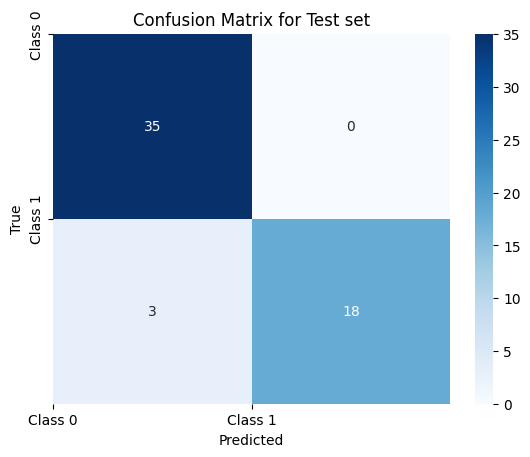

In [37]:
bc.train_and_evaluate_model(decision_tree,
                            X.copy(), y.copy(),
                            X_test.copy(), y_test.copy(),
                            save_outputs=True, output_dir=OUTPUT_PATH)

This model could benefit from more data to improve its generalization. Generalization on unseen data is good as seen in the confusion matrix. But Logistic regression remains as the best model so far which is reflected in all metrics.

Final scores for Decision Tree model:

| Accuracy | Precision | Recall | F1 Score | AUC ROC |
|----------|-----------|--------|----------|---------|
| 0.9464   |    1.0    | 0.8571 | 0.9231   | 0.9286  |

### Random Forest:

**Default params:**

In [38]:
model_obj = Model('RandomForest', optimization=False)

{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


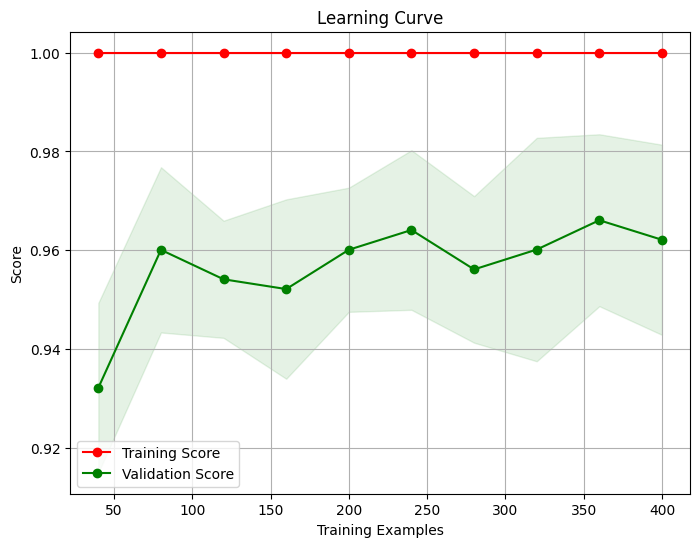

In [39]:
print(model_obj.hyperparameters)
bc.plot_learning_curve(model_obj, X.copy(), y.copy(), cv=5)

The training score (red line) is consistently 1.0, indicating that the model is perfectly fitting the training data. This is a strong sign of overfitting, as the model has learned the training data too well, capturing noise along with the underlying patterns.

The validation score (green line) fluctuates around 0.93 to 0.96, indicating that the model's performance on unseen data is significantly lower than on the training data. This supports the indication of overfitting.

The validation score does not significantly improve or stabilize as the training size increases, suggesting that adding more data alone may not resolve the overfitting issue.

For model RandomForest with {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}:

Results for train set:

   accuracy  precision  recall   f1  auc_roc
0       1.0        1.0     1.0  1.0      1.0

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9464       0.95  0.9048  0.9268   0.9381


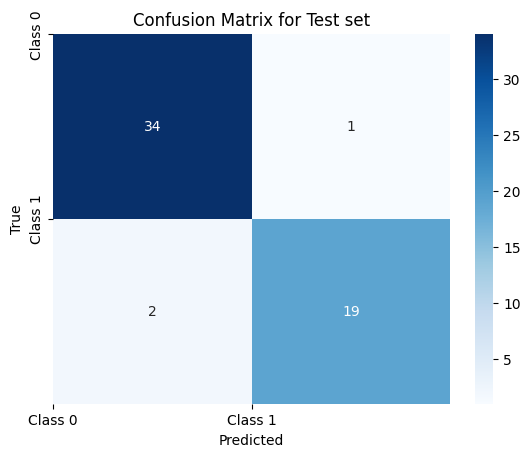

In [40]:
bc.train_and_evaluate_model(model_obj,
                            X.copy(),y.copy(),
                            X_test.copy(), y_test.copy())

**Hyperparameter optimization:**

In [41]:
# Hyperparameter_optimization
model_obj = Model('RandomForest', optimization=True)
print(f'Hyperparameters to optimize : {model_obj.hyperparams_to_optimize}')
best_params = bc.hyperparameter_optimization(model_obj.model,
                                             model_obj.hyperparams_to_optimize,
                                             X.copy(),
                                             y.copy(),
                                             cv=8)

Hyperparameters to optimize : {'n_estimators': [10, 20, 50, 100], 'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', 0.5]}
Best hyperparameters found: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Best score: 0.9741


{'n_estimators': 20, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}


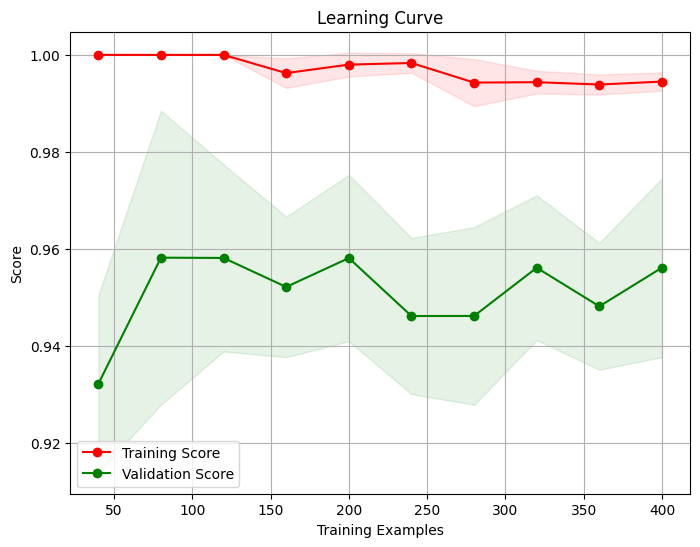

In [42]:
# Study with best params.
random_forest = Model('RandomForest', kwargs=best_params)
print(random_forest.hyperparameters)
bc.plot_learning_curve(random_forest, X.copy(), y.copy(), cv=5)

The training score starts very high (close to 1.0), indicating that the model fits the training data almost perfectly when the data size is small. As the size of the training data increases, the training score slightly decreases but remains high, suggesting that the model maintains a strong fit to the training data even with more data.

The validation score starts lower compared to the training score, indicating that the model does not generalize as well to unseen data initially.

As the training data size increases, the validation score improves, showing that the model's generalization capability improves with more data.

The validation score shows some fluctuations but generally trends upward, suggesting that more data helps the model generalize better.

The learning curve suggests that the model starts with overfitting when trained on smaller datasets but improves its generalization capability as more training data is used.

**Optimized model:**

For model RandomForest with {'n_estimators': 20, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}:

Results for train set:

   accuracy  precision  recall      f1  auc_roc
0     0.996        1.0  0.9892  0.9946   0.9946

Results for test set:

   accuracy  precision  recall   f1  auc_roc
0    0.9286     0.9474  0.8571  0.9   0.9143


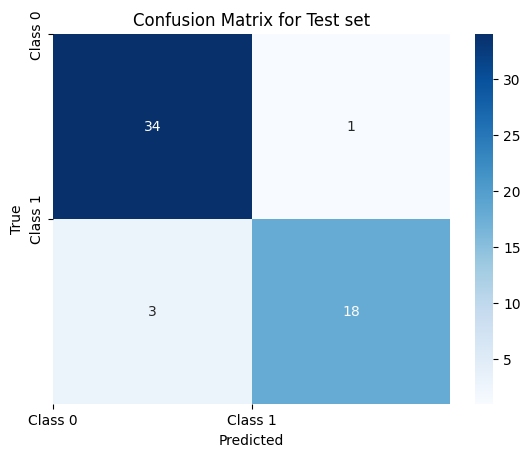

In [43]:
bc.train_and_evaluate_model(random_forest,
                            X.copy(),y.copy(),
                            X_test.copy(), y_test.copy(),
                            save_outputs=True, output_dir=OUTPUT_PATH)

From the confusion matrix it can be concluded that the model is able to predict with an almost perfect accuracy the class 0 and has a prety good accuracy on predicting the class 1 on unseen data. So it seems the model is able to generalize well.

Final results for r=Random forest for the test set: 

|   accuracy |   precision |   recall |    f1 |   auc_roc |
|------------|-------------|----------|-------|-----------|
|     0.9286 |      0.9474 |  0.8571  |  0.9  |    0.9143 |

This model produces the same test results in all metrics as the logistic regression model.

### SVM

**Default params:**

In [44]:
model_obj = Model('Svm', optimization=False)

{'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'class_weight': None}


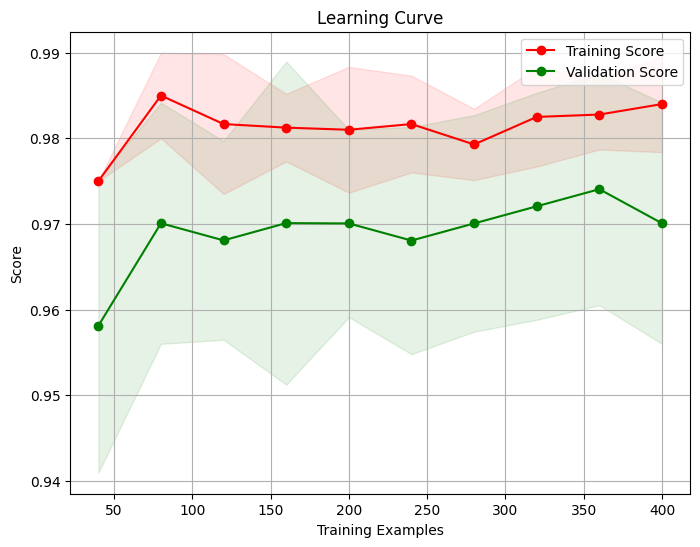

In [45]:
print(model_obj.hyperparameters)
bc.plot_learning_curve(model_obj, X.copy(), y.copy(), cv=5)

The training score starts very high (close to 1.0) and gradually decreases as the number of training examples increases. This indicates that the model is overfitting when the training set is small, but as more data is added, the overfitting reduces.

The validation score remains relatively stable, with minor fluctuations, staying around 0.97. The consistent validation score suggests that the model's generalization performance does not significantly degrade as more training examples are added.

The gap between the training score and the validation score indicates the model's variance. Initially, there is a noticeable gap, which suggests high variance (overfitting). However, this gap decreases as more training data is added, reducing the variance. The relatively high and stable validation score suggests that the model has a low bias.

Overall, the model performs well on both the training and validation sets, with scores above 0.96. The slight decrease and then recovery in the training score, combined with the stable validation score, suggests that the model could benefit from more training data to achieve more stable and higher performance.

For model Svm with {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'class_weight': None}:

Results for train set:

   accuracy  precision  recall      f1  auc_roc
0     0.986     0.9944  0.9676  0.9808   0.9822

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9643     0.9524  0.9524  0.9524   0.9619


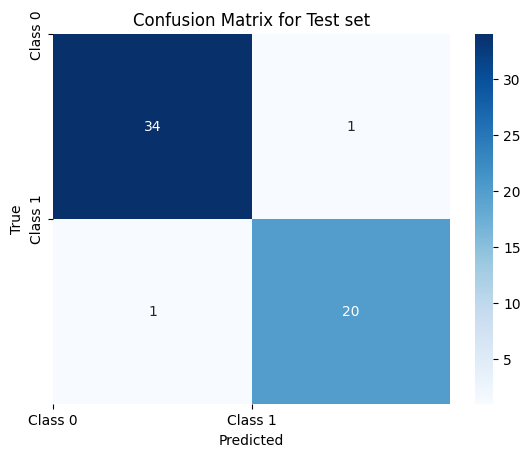

In [46]:
bc.train_and_evaluate_model(model_obj,
                            X.copy(),y.copy(),
                            X_test.copy(), y_test.copy())

**Hyperparameter optimization:**

In [47]:
# Hyperparameter_optimization
model_obj = Model('Svm', optimization=True)
print(f'Hyperparameters to optimize : {model_obj.hyperparams_to_optimize}')
best_params = bc.hyperparameter_optimization(model_obj.model,
                                             model_obj.hyperparams_to_optimize,
                                             X.copy(),
                                             y.copy(),
                                             cv=8)

Hyperparameters to optimize : {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto', 0.1, 1], 'degree': [2, 3, 4], 'class_weight': [None, 'balanced']}
Best hyperparameters found: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
Best score: 0.9841


{'C': 0.1, 'kernel': 'poly', 'gamma': 1, 'degree': 3, 'class_weight': None}


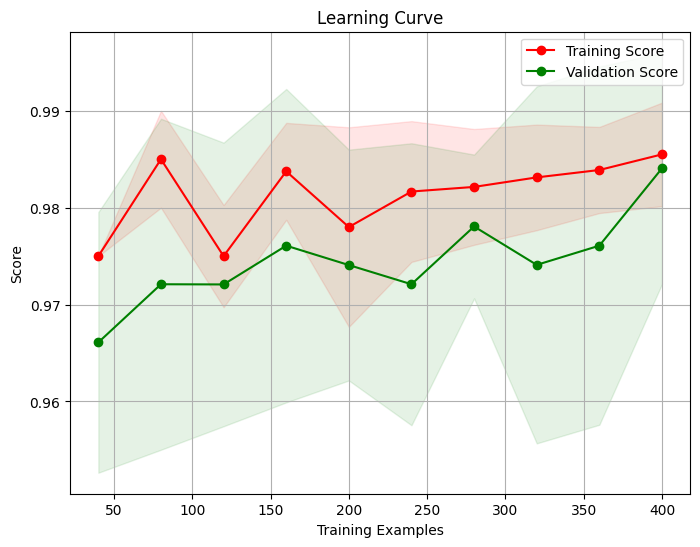

In [48]:
# Study with best params.
svm = Model('Svm', kwargs=best_params)
print(svm.hyperparameters)
bc.plot_learning_curve(svm, X.copy(), y.copy(), cv=5)

The training score shows fluctuations but generally increases as the number of training examples increases, reaching above 0.985 for the largest training set.
This suggests that the model's performance improves with more training data.

The validation score also shows some fluctuation but generally increases in parallel with the training score, achieving similar high scores above 0.98 with the largest training set.
The convergence of the validation score with the training score suggests that the model generalizes well to unseen data.

Initially, there is a gap between the training and validation scores, indicating some variance. However, as the training set size increases, this gap decreases.

As the training set size increases, the variability in the validation score decreases, indicating more stable performance with more data.

The convergence of the training and validation scores at higher training set sizes indicates that the model is neither overfitting nor underfitting significantly, showing low bias and low variance.

Overall, the model shows high performance on both the training and validation sets, with scores above 0.965.

For model Svm with {'C': 0.1, 'kernel': 'poly', 'gamma': 1, 'degree': 3, 'class_weight': None}:

Results for train set:

   accuracy  precision  recall      f1  auc_roc
0     0.986      0.989   0.973  0.9809   0.9833

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9643     0.9524  0.9524  0.9524   0.9619


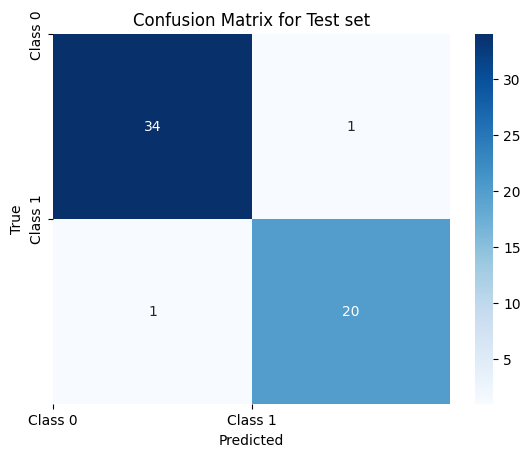

In [49]:
bc.train_and_evaluate_model(svm,
                            X.copy(),y.copy(),
                            X_test.copy(), y_test.copy(),
                            save_outputs=True, output_dir=OUTPUT_PATH)

Confusion matrix shows good generalization. The model is able to correctly predict with a 100% accuracy the class 0  with a very good accuracy for correctly predicting class 1.

Final results for SVM on test set:

|   accuracy |   precision |   recall |    f1  |   auc_roc |
|------------|-------------|----------|------- |-----------|
|     0.9643 |    0.9524   |  0.9524  | 0.9524 |    0.9619 |

Results on test set are the same as Random Forest and logistic regression models.

### Naive Bayes

In [50]:
naive_bayes = Model('NaiveBayes', optimization=False) # No optimization for this model.

{'priors': None}


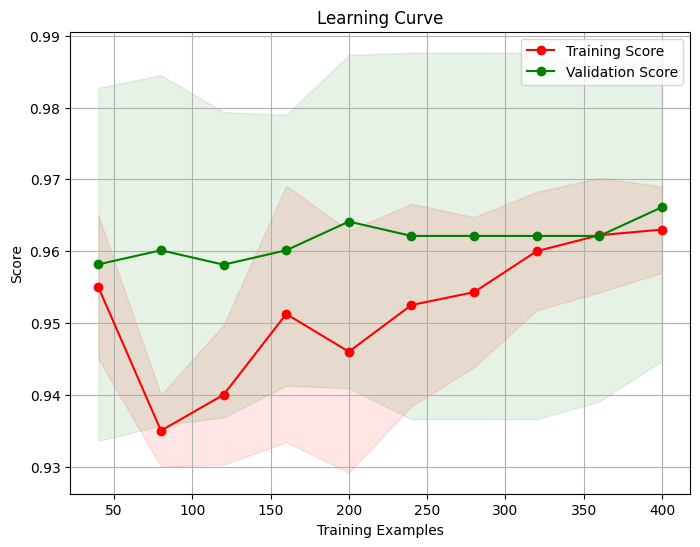

In [51]:
print(naive_bayes.hyperparameters)
bc.plot_learning_curve(naive_bayes, X.copy(), y.copy(), cv=5)

Initially, the model performs better on the validation set than on the training set. Naive Bayes inherently applies a form of regularization, which might prevent overfitting on the small initial training set, leading to better performance on the validation set. With very small training data, the model may not have learned enough patterns, causing higher training error compared to the validation set.

As more training data is added, the performance of the model on both the training and validation sets improves.

The slight decrease in both scores towards the end might indicate that the model starts to overfit the noise in the training data as the dataset grows larger or the additional data towards the end might be noisier or less representative, causing a decrease in performance.

For model NaiveBayes with {'priors': None}:

Results for train set:

   accuracy  precision  recall      f1  auc_roc
0    0.9621     0.9415  0.9568  0.9491    0.961

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9643     0.9524  0.9524  0.9524   0.9619


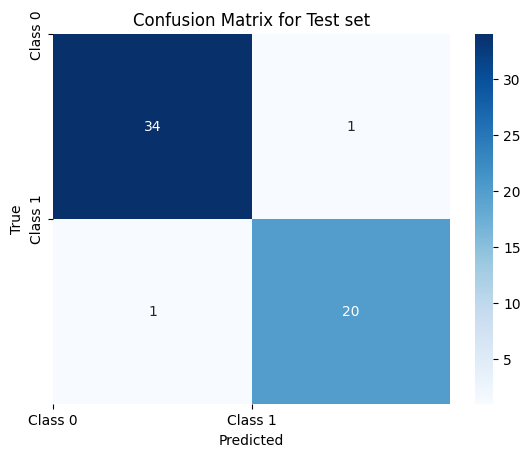

In [52]:
bc.train_and_evaluate_model(naive_bayes,
                            X.copy(),y.copy(),
                            X_test.copy(), y_test.copy(),
                            save_outputs=True, output_dir=OUTPUT_PATH)

Confusion matrix is pretty similar to the ones from the other models. In general we get good accuracies and generalization. But other models that we have already seen, outperform naive bayes. 

Finally scores for Naive Bayes model:

|   accuracy   | precision | recall  |   f1   | auc_roc |
|--------------|-----------|---------|--------|---------|
|    0.9474    |    1.0    |  0.8571 | 0.9231 |  0.9286 |

### Ensemble Methods:

Let's try to apply an ensemble method with a voting scheme with the models that have performed better in an attempt to improve the overall results.

#### Voting:

In [53]:
# Ensamble voting classifier
estimators = [{'name':'LogisticRegression', 'params': log_reg.hyperparameters},
              {'name': 'Svm', 'params': svm.hyperparameters},
              {'name':'RandomForest', 'params': random_forest.hyperparameters}]
ensembler = Model('EnsambleVoting', estimators_info=estimators, optimization=False)

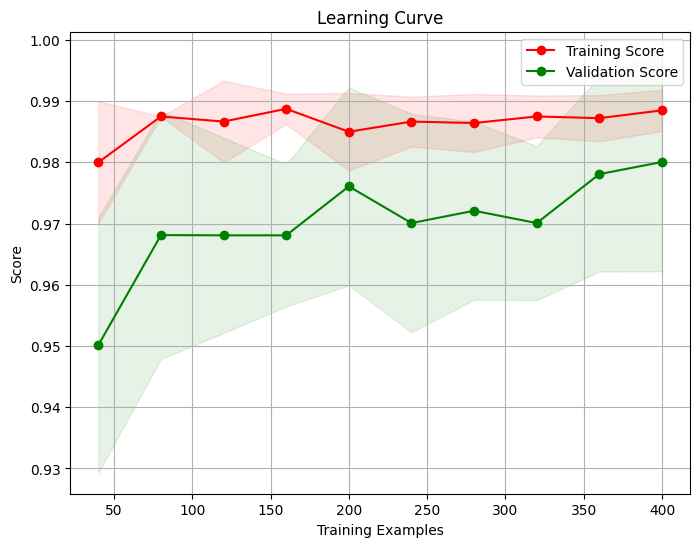

In [54]:
bc.plot_learning_curve(ensembler, X.copy(), y.copy(), cv=5)

For model EnsambleVoting with {'LogisticRegression__penalty': 'l2', 'LogisticRegression__c_reg': 1.0, 'LogisticRegression__solver': 'newton-cg', 'LogisticRegression__max_iter': 10000, 'Svm__C': 0.1, 'Svm__kernel': 'poly', 'Svm__gamma': 1, 'Svm__degree': 3, 'Svm__class_weight': None, 'RandomForest__n_estimators': 20, 'RandomForest__max_depth': 5, 'RandomForest__min_samples_split': 2, 'RandomForest__min_samples_leaf': 1, 'RandomForest__max_features': 0.5}:

Results for train set:

   accuracy  precision  recall      f1  auc_roc
0     0.988     0.9945   0.973  0.9836   0.9849

Results for test set:

   accuracy  precision  recall      f1  auc_roc
0    0.9643     0.9524  0.9524  0.9524   0.9619


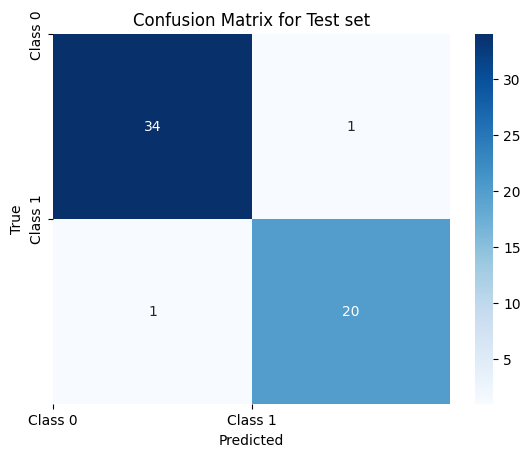

In [55]:
bc.train_and_evaluate_model(ensembler,
                            X.copy(),y.copy(),
                            X_test.copy(), y_test.copy(),
                            save_outputs=True, output_dir=OUTPUT_PATH)

Finally scores for Ensemble method:              

|   accuracy   | precision | recall  |   f1   | auc_roc |
|--------------|-----------|---------|--------|---------|
|    0.9649    |    1.0    |  0.9048 | 0.95   |  0.9524 |

Ensemble method do not improve the results for the individual models.

### Conclusions

We have obtained exactly the same results for models:
- Logistic Regression.
- SVM.
- Random Forest.
- Ensemble method.

As per model selection:

Ensemble method is discarted due to the increased complexity on ensembling all models.

Logistic Regression:
- Pros: Simple and interpretable, efficient for large datasets, suitable for linearly separable data.
- Cons: Limited to linear decision boundaries, prone to underfitting complex data.

Support Vector Machines (SVMs):
- Pros: Versatile in handling both linear and non-linear decision boundaries, intermediate interpretability.
- Cons: Can be less scalable, prone to overfitting without proper regularization.

Random Forest:
- Pros: Robust to overfitting, efficient for large datasets, captures complex non-linear relationships.
- Cons: Less interpretable due to ensemble nature, may require more memory and computational resources.

Considerations:

- Interpretability: Logistic regression is the model with a higher inverpretability.
- Scalability: For large datasets, logistic regression and random forest are more scalable.
- Robustness to Overfitting: Random forest is robust, while SVMs require careful regularization.
- Handling Non-Linearity: Random forest and SVMs are better at capturing non-linear relationships.
- Computational Efficiency: Logistic regression is generally the most computationally efficient, followed by random forest and SVMs.


Taking into account all considerations. Logistic Regression will be the selected model.